#### Perform a variety of pre-processing steps on images

* Image Loading
* Image Resizing (All images are 224 X 224 X 3 in jpg format)
* Image Cropping (All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image)
* Convert to Grayscale 
* Image Enhancement (histogram equalization, sharpening, noise reduction, etc.)
* Normalization
* Data Augmentation: Apply data augmentation techniques to increase the size and diversity of your dataset. This can include random rotations, flips, translations, or other transformations to simulate different viewpoints or variations in lighting conditions.
* Image Filtering: : Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local


import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam


from glob import glob


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

## Image Loading

In [3]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [4]:
path_df['suit'] = path_df['labels'].str.split().str[-1]
print(path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [5]:
# Remove rows with jokers
path_df = path_df[~path_df['suit'].str.contains('joker', case=False)]
print("Unique suits without Jokers: ", path_df['suit'].unique())

Unique suits without Jokers:  ['clubs' 'diamonds' 'hearts' 'spades']


In [6]:
# Remove columns that are not needed


path_df = path_df.drop(columns = ['data_set'])
path_df = path_df.drop(columns = ['class_index'])
# path_df = path_df.drop(columns = ['labels'])
path_df = path_df.drop(columns = ['card_type'])
path_df.head()

,filepaths,labels,suit
0,train/ace of clubs/001.jpg,ace of clubs,clubs
1,train/ace of clubs/002.jpg,ace of clubs,clubs
2,train/ace of clubs/003.jpg,ace of clubs,clubs
3,train/ace of clubs/004.jpg,ace of clubs,clubs
4,train/ace of clubs/005.jpg,ace of clubs,clubs


## Check Image Size

In [7]:
# All images are 224 X 224 X 3 in jpg format
# Double check by printing out unique shapes of images

image_shapes = []

for folder in path_df.suit.unique():
    for filepath in path_df[path_df.suit == folder].filepaths:
        image = cv2.imread('Dataset/' + filepath)

        if (filepath[-3:] == "jpg"):

            # Obtain shape of each image and store them in an array
            (width, height) = image.shape[1], image.shape[0]
            image_shapes.append((width, height))
    
# Return only unique shapes
unique_shapes = list(set(image_shapes))
print(unique_shapes)


[(224, 224)]


## Convert Images to Grayscale

In [8]:
# Convert images to grayscale

def convert_to_grayscale(filepath):
    filename = 'Dataset/' + filepath
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

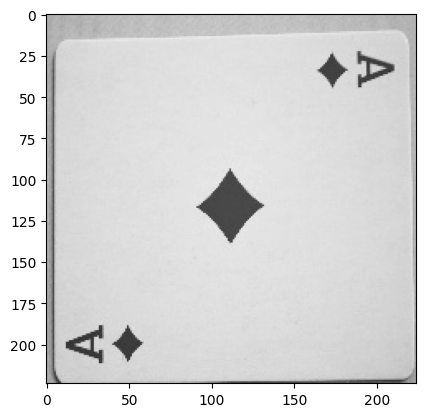

In [9]:
# Test if an image is actually gray

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
plt.imshow(test_gray_img, cmap='gray', vmin=0, vmax=255)

## Image Enhancement

Apply techniques to improve the image quality or highlight specific features. Includes contrast stretching, histogram equalization, and sharpening

In [10]:
#logarithmic correction - replaces pixels with their log value
def log_correction(image):
    log_adjusted_image =  exposure.adjust_log(image)
    return log_adjusted_image

#gamma correction - adjusts brightness of image
def gamma_correction(image):
    random_gamma = np.random.uniform(low = 0, high = 1)
    
    gamma_adjusted_image = exposure.adjust_gamma(log_correction(image), 2)
    return gamma_adjusted_image

# BLURRING AND SHARPENING
# Blurring the image
def blur_image(image):
    blur_img = gaussian(gamma_correction(image), sigma = 3)
    return blur_img

# Sharpening image
def sharpen_image(image):
    blurred_image = blur_image(image)
    sharp_img = image + (image - blurred_image)
    return sharp_img

# NORMALIZATION
def normalize_img(image):
    normalized = (sharpen_image(image) - np.min(sharpen_image(image)))/(np.max(sharpen_image(image)) - np.min(sharpen_image(image)))   
    return normalized

### Preprocess images and save to DatasetPreProcessed folder

In [ ]:
# Preprocess images and save to a new folder called 'DatasetPreProcessed'

for index, row in path_df.iterrows():
    filepath = row['filepaths']
    image = convert_to_grayscale(filepath) #convert to grayscale
    preprocessed_image = normalize_img(image) #log correction, gamma correction, blurred, sharpened, and normalized
    scaled_preprocessed_image = (preprocessed_image * 255).astype(np.uint8) #scale images
    
    # save preprocessed images to new DatasetPreProcessed folder
    directory = os.path.split('./DatasetPreProcessed/' + filepath)[0] 
    os.makedirs(directory, exist_ok=True)
    save_path = os.path.join(directory, os.path.basename(filepath))

    # save normalized images
    cv2.imwrite(save_path, scaled_preprocessed_image)


### Train-Train-Validation Split

In [ ]:
# Splitting into train, test, and validation sets (80% - 10% - 10% split)

# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

In [ ]:
# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

### Data Augmentation
Apply data augmentation techniques to increase the size and diversity of dataset. This include rotations, flips, and augmentation. This simulate different viewpoints or variations.

In [ ]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
# Create data generators for train, validation, and test

batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


### To train models use:
* train_generator
* valid_generator
* test_generator